# 03) Improve labels

A key problem with the headlines data is that the keyword matching process during data collection likely missed many non-risk headlines, meaning the dataset liekly contains mislabelled data. To tackle this problem, a regression model for each language (Spanish and Portuguese) is trained on half of the data at a time to generate predictions for the other half's headlines. A percentage of headlines at a certain probability score from each half is kept, helping to eliminate many false negatives and tackling the class imbalance problem (see notebook 1). 

## Read-in data

Seperate dataframes are created for each language (Spanish & Portuguese). 

In [1]:
import pandas as pd
import numpy as np

# read-in data
df = pd.read_csv('../Data/original_headlines.csv', encoding='utf-8')
print(str(round(len(df)/1000, 1)) + 'K Total headlines')

# include only spanish 
spanish_df = df[df.country.isin(['Argentina', 'Colombia', 'Mexico'])].reset_index(drop=True)
print(str(round(len(spanish_df)/1000, 1)) + 'K Spanish headlines')

# include only portuguese 
portuguese_df = df[df.country == 'Brazil'].reset_index(drop=True)
print(str(round(len(portuguese_df)/1000, 1)) + 'K Portuguese headlines')

95.2K Total headlines
77.3K Spanish headlines
15.2K Portuguese headlines


## Clean data

### Remove duplicates & thumbnails

Headlines containing the word thumbnail are normally videos which cannot be scraped. Many of these with a similar format in the non-risk headlines data add little value in terms of variety and therefore are removed.

In [2]:
# remove duplicates
spanish_df.drop_duplicates(subset='headline', inplace=True)
portuguese_df.drop_duplicates(subset='headline', inplace=True)

# remove thumbnails
spanish_df = spanish_df[~spanish_df['headline'].str.lower().str.contains('thumbnail', na=False)]
portuguese_df = portuguese_df[~portuguese_df['headline'].str.lower().str.contains('thumbnail', na=False)]

# removes english headlines from the spanish dataset
spanish_df = spanish_df.loc[~spanish_df.website.isin(['Colombia Reports'])]

# reset index
spanish_df.reset_index(drop=True, inplace=True)
portuguese_df.reset_index(drop=True, inplace=True)

### Clean headline text

The text is subjected to common cleaning techniques to reduce dimensionality.

In [3]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('Spanish'))
portuguese_stop_words = set(stopwords.words('Portuguese'))

# common text cleaning techniques
def clean_text(text, language):
    text = text.strip()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '¡¿'))

    if language=='Spanish':
        text = ' '.join([word for word in text.split() if word not in spanish_stop_words])
    elif language=='Portuguese':
        text = ' '.join([word for word in text.split() if word not in portuguese_stop_words])
    
    return text

spanish_df['headline'] = [clean_text(x, 'Spanish') for x in spanish_df['headline']]
portuguese_df['headline'] = [clean_text(x, 'Portuguese') for x in portuguese_df['headline']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Put aside data

### Split datasets

A percentage of the data from each dataframe is put aside. This is useful to make sure we don't end up evaluating on an artificially easy dataset in which most of the more difficult edge cases for non-risk headlines have been removed. 

In [4]:
import random 

# returns the main dataframe and a random sample to be put aside for evaluation
def put_aside_random_percent(df, percent):
    indices = list(df.index)
    dividor = int(100 / percent)
    sample_size = int(np.floor(len(indices)/dividor))
    random_sample = random.sample(indices, sample_size)
    put_aside_headlines = df.iloc[random_sample,:].reset_index(drop=True)
    df = df.loc[~df.index.isin(random_sample)].reset_index(drop=True)
    return df, put_aside_headlines

spanish_df_post_sample, raw_spanish_put_aside_df = put_aside_random_percent(spanish_df, 10)
portuguese_df_post_sample, raw_portuguese_put_aside_df = put_aside_random_percent(portuguese_df, 10)

### Curate put aside df

The put aside dataframe is filtered to include only keyword matches. While this drastically reduces the non-risk headlines, it also reduces the risk of evaluating on mislabeled data (due to risk headlines that were not keyword matched). It also means we are evaluating on a dataset that includes many of the more difficult non-risk edge cases and not an artificially easy one in which many of them have been removed.

In [5]:
# filteres non-risks to include only keyword matches
def filter_put_aside_df(df, title):
    print()
    print('*** ' + title + ' ***')
    print()
    keyword_hits = df.loc[~pd.isna(df.keyword_hit)]
    non_risks = keyword_hits.loc[pd.isna(keyword_hits.risk_type)]
    risks = keyword_hits.loc[~pd.isna(keyword_hits.risk_type)]
    print('non-risks: ' + str(len(non_risks)))
    print('risks: ' + str(len(risks)))
    return pd.concat([risks, non_risks])

spanish_put_aside_df = filter_put_aside_df(raw_spanish_put_aside_df, 'Spanish')
portuguese_put_aside_df = filter_put_aside_df(raw_portuguese_put_aside_df, 'Portuguese')


*** Spanish ***

non-risks: 459
risks: 928

*** Portuguese ***

non-risks: 214
risks: 332


## Improve label quality

### Split dataframe

Each dataframe is randomly split into two sets so a model can be trained on each set and used to predict headlines for the other.

In [6]:
# randomly split a dataframe into 2 equal size groups 
def split_dataframes(df):
    population = list(range(len(df)))
    half_headlines = int(np.floor(len(population) / 2))
    random_samples = random.sample(population, half_headlines)
    return df.loc[random_samples,:].reset_index(drop=True), df.loc[~df.index.isin(random_samples), :].reset_index(drop=True)

### Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data and fits a model 
def fit_model(df):
    X, y = df.headline, [int(pd.notna(x)) for x in df.risk_type]
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(train_tfidf, y)
    return vectorizer, model

### Generate predictions

Predictions from one half of each dataset are added to the other half.

In [8]:
# returns predictions as binary decisions and probabilities
def predict_headlines(df, vectorizer, model):
    tfidf_vectors = vectorizer.transform(df.headline)
    y_preds = model.predict(tfidf_vectors)
    y_pred_prob = [np.mean(model.predict_proba(x)[:, 1]) for x in tfidf_vectors]
    return y_preds, y_pred_prob 

# adds the predictions for each half of the data to their respective dfs
def add_predictions_to_df(primary_df, secondary_df):
    vectorizer, model = fit_model(secondary_df)
    y_preds, y_pred_prob = predict_headlines(primary_df, vectorizer, model)
    primary_df['y_pred'], primary_df['y_pred_prob'] = y_preds, y_pred_prob
    primary_df.sort_values('y_pred_prob', ascending=False, inplace=True)
    return primary_df

# returns a headlines dataframe along with their predictions for veiwing
# this is useful so we can set appropriate upper and lower limits for the 
# slice of low probability non-risk headlines we will select later on
def return_headline_preds(df, language):
    df_1, df_2 = split_dataframes(df) 
    df_1, df_2 = add_predictions_to_df(df_1, df_2), add_predictions_to_df(df_2, df_1)
    #df_1, df_2 =  drop_non_risk_headlines(df_1, language), drop_non_risk_headlines(df_2, language)
    return df_1, df_2

spanish_df_1, spanish_df_2 = return_headline_preds(spanish_df_post_sample, 'Spanish')
portuguese_df_1, portuguese_df_2 = return_headline_preds(portuguese_df_post_sample, 'Portuguese')

### Find false negatives threshold

The threshold at which false negatives are no longer common is located and used for the upper limits in the next step.

In [9]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
def view_nonrisk_highest_rows(df, start, end):
    temp_df = df.loc[pd.isna(df.risk_type)].sort_values('y_pred_prob')
    print()
    print('Non-risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent

spanish_false_negative_percent = view_nonrisk_highest_rows(spanish_df_1, 8990, 9000)
portuguese_false_negative_percent = view_nonrisk_highest_rows(portuguese_df_1, 2090, 2100)


Non-risk headlines: 26572

12891:   astróloga cubana mhoni vidente nuevamente lanzó cartas advirtió quién ganador partido colombia vs uruguay
3263:   próximo feriado martes 9 julio puente lunes 8
17608:   solicitan colonos mayor vigilancia fraccionamiento sq
943:   apertura bolsa valores tokio anticipan jornada tranquila mercados globales tras impacto derrumbe nikkei lune segundo mayor historia
15192:   intensifican seguridad sector comercio capital nariñense
25850:   portada6 horas presenta héctor magaña “la voz pueblo” dio conocer estrategia plan municipal desarrollo josefina herrera noticias presidente municipal electo tequisquiapan héctor magaña rentería
20621:   prográmese conozca fecha límite declarar renta según número cédula
8767:   cancillería anunció activó mecanismos esclarecer caso iniciar debidos protocolos luego denuncia embajador
28180:   julián camilo merchán jiménez
4251:   demolieron edificio colapsó medellín 24 riesgo vengan abajo

Non-risk headlines: 5038

200:   n

### Drop false negatives

All non-risk headlines above the threshold above are dropped, eliminating many false negatives and tackling the class imbalance problem (see notebook 1).

In [10]:
# drops a number of non-risk headlines based on their prediction scores
def drop_non_risk_headlines(df, percent):   
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(non_risk_df) * percent))
    low_score_non_risk = non_risk_df.iloc[(len(non_risk_df)-upper_limit):(len(non_risk_df)-lower_limit),:]
    return pd.concat([risk_df, low_score_non_risk])

# creates a filtered dataframe combining both halfs of the data 
# after dropping headlines with high predictions
def create_filtered_df(df_1, df_2, percent):
    df_1, df_2 =  drop_non_risk_headlines(df_1, percent), drop_non_risk_headlines(df_2, percent)
    return pd.concat([df_1, df_2])

false_negatives_filtered_spanish_df = create_filtered_df(spanish_df_1, spanish_df_2, spanish_false_negative_percent)
false_negatives_filtered_portuguese_df = create_filtered_df(portuguese_df_1, portuguese_df_2, portuguese_false_negative_percent)

### Find false positives threshold

The threshold for false positives is found by exploring the data.

In [11]:
# this function shows the risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false positives in the data...
def view_risk_lowest_rows(df, start, end):
    temp_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob').reset_index(drop=True)
    print()
    print('Risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_spanish_df, 60, 70)
portuguese_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_portuguese_df, 40, 50)


Risk headlines: 8546

60:   redacción atrapan presunto narco 100 dosis metanfetaminaseguridad agosto 15 2024 0300 am resultado trabajos operativos inteligencia desarrollados guardia civil estatal gce co
61:   tendieron emboscada ismael mayo zambada
62:   cómo sacar citas hacer cursos pedagógicos conseguir rebajas multas tránsito
63:   vuelca camión carga anillo periférico norteseguridad agosto 13 2024 0300 am
64:   redacción vándalos cargaban armas prohibidasseguridad julio 28 2024 0300 am diferentes recorridos seguridad vigilancia efectivos guardia civil estatal detuvieron cinco personas
65:   mayo zambada traicionado hijo chapo entregó dice wsj
66:   movilización centro tizimín cristalazo tienda celulares
67:   fotos abandonan vehículos cargados miles cigarrillos extranjeros
68:   conozca cartel buscados ibagué personas implicadas varios delitos graves
69:   anuncio arancel 48 vehículos chinos podría desencadenar medidas china

Risk headlines: 3002

40:   colunas moraes manda soltar

### Drop false positives

Many false posiitves are dropped from the data based on their percentage ranking when ordered by their y preds.

In [12]:
# drops a number of risk headlines based on their prediction scores
def drop_risk_headlines(df, percent):   
    risk_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob')
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(risk_df) * percent))
    high_score_risk = risk_df.iloc[upper_limit:len(risk_df),:]
    combined_df = pd.concat([high_score_risk, non_risk_df])
    return combined_df.reset_index(drop=True)

false_positives_filtered_spanish_df = drop_risk_headlines(false_negatives_filtered_spanish_df, spanish_false_positive_percent)
false_positives_filtered_portuguese_df = drop_risk_headlines(false_negatives_filtered_portuguese_df, portuguese_false_positive_percent)

## Evaluate performance

### Train test split

Creates a train test split for a given dataframe.

In [13]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.25):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

### Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# creates a confusion matrix heatmap
def heatmap(conf_matrix_df, colors):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_df, annot=True, cmap=colors, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# evaluates the model's performance and prints the results
def evaluate_model(model, X_test_tfidf, y_test, colors):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print()
    print("Classification Report:\n", classification_report_)
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Risk', 'Actual Risk'], columns=['Pred Non-Risk', 'Pred Risk'])
    heatmap(conf_matrix_df, colors)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

### Check results

A model is trained on the filtered dataset and evaluated on the set aside data. As we can see, the recall for risk headlines (the main business objective of this project) has improved dramatically for both languages (see notebook 2). 

In [15]:
# evaluates a filtered dataset against new headlines
def logistic_regression(train_df, put_aside_df, language, colors):
    print()
    print('*** ' + language + ' ***')
    print()

    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.01)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    print(str(round(len(put_aside_df)/1000, 2)) + 'K put aside headlines')
    
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]

    return evaluate_model(model, X_test_tfidf, y_test, colors)

### Evaluate original labels 

Evaluates the results of using the original labels.


*** Spanish ***

1.39K put aside headlines
Accuracy: 0.652

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.85      0.62       459
           1       0.88      0.56      0.68       928

    accuracy                           0.65      1387
   macro avg       0.68      0.70      0.65      1387
weighted avg       0.75      0.65      0.66      1387




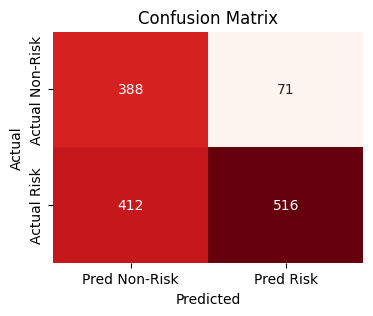



*** Portuguese ***

0.55K put aside headlines
Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.92      0.71       214
           1       0.91      0.56      0.69       332

    accuracy                           0.70       546
   macro avg       0.74      0.74      0.70       546
weighted avg       0.78      0.70      0.70       546




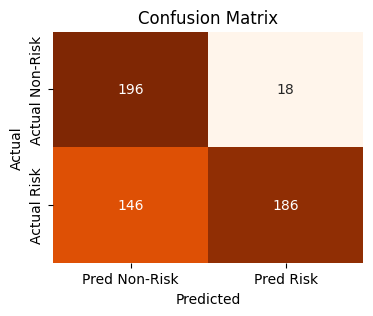

In [16]:
# trains and evaluates a model on the unfiltered data
unfiltered_spanish_classification_report_ = logistic_regression(spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
unfiltered_portuguese_classification_report_ = logistic_regression(portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

### Evaluate improved labels

Evaluates the results of using the improved labels.


*** Spanish ***

1.39K put aside headlines
Accuracy: 0.725

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.38      0.48       459
           1       0.75      0.90      0.81       928

    accuracy                           0.73      1387
   macro avg       0.69      0.64      0.65      1387
weighted avg       0.71      0.73      0.70      1387




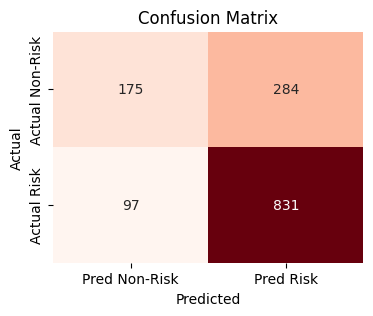



*** Portuguese ***

0.55K put aside headlines
Accuracy: 0.716

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.50      0.58       214
           1       0.73      0.85      0.79       332

    accuracy                           0.72       546
   macro avg       0.71      0.68      0.68       546
weighted avg       0.71      0.72      0.71       546




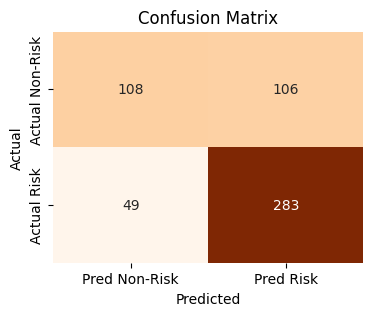

In [17]:
# trains and evaluates a model on the filtered data
filtered_spanish_classification_report_ = logistic_regression(false_positives_filtered_spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
filtered_portuguese_classification_report_ = logistic_regression(false_positives_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

## Repeat false negative filtering

Given that the process above improved the model, it stands to reason that repeating the false negative filtering process with predictions based on the newly refined dataset could improve the model even further. The results below show that although the overall accuracy for both models declined (likely because we are dropping badly needed data), the most important metric for this project (risk headlines recall) went up in both datasets. 

### Generate new predictions

In [18]:
# resets the indices
false_positives_filtered_spanish_df.reset_index(drop=True, inplace=True)
false_positives_filtered_portuguese_df.reset_index(drop=True, inplace=True)

# creates additional dataframes with new predictions based on a model trained on the newly filtered dataframe
spanish_df_3, spanish_df_4 = return_headline_preds(false_positives_filtered_spanish_df, 'Spanish')
portuguese_df_3, portuguese_df_4 = return_headline_preds(false_positives_filtered_portuguese_df, 'Portuguese')

### Find new false negatives threshold

In [19]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
new_spanish_percent = view_nonrisk_highest_rows(spanish_df_4, 7001, 7011)
new_portuguese_percent = view_nonrisk_highest_rows(portuguese_df_4, 1681, 1691)


Non-risk headlines: 9054

10732:   nación giro caso ecuatoriana falleció medellín ninguna intervención
4586:   niña falleció tras ser enviada casa corte suprema condenó médico negligencia
9456:   hace 47 años partía plata último tren estación provincial
5033:   rodolfo hernández uci después cirugía cáncer terminal padece
6105:   insólita excusa asesino volante camino buen ayre
8982:   ana castillo visitó tumba omar geles ahijada “la sonrisa papá”
5556:   muestran ‘músculo’ corporaciones seguridad coahuila
4587:   quinceañera hospitalizada tras resbalar campo plena lluvia
11678:   diligencia supervisada despacho magistrado francisco farfán aunque encontraba presente lugar
5820:   celebrar responsabilidad

Non-risk headlines: 2126

1545:   licenciamento veículos sp começa vencer veja calendário pagar
2930:   saúde pública fabricante vacina contra mpox pede autorização imunizar adolescentes
3376:   05 revelação amante yuri tentou vender informações r 30 mil diz iza
1745:   brasileirãocor

### Drop headlines and evaluate new results


*** Spanish ***

1.39K put aside headlines
Accuracy: 0.722

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.29      0.41       459
           1       0.73      0.93      0.82       928

    accuracy                           0.72      1387
   macro avg       0.71      0.61      0.61      1387
weighted avg       0.71      0.72      0.68      1387




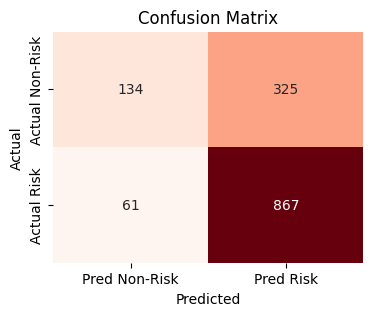



*** Portuguese ***

0.55K put aside headlines
Accuracy: 0.716

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.43      0.54       214
           1       0.71      0.90      0.79       332

    accuracy                           0.72       546
   macro avg       0.72      0.67      0.67       546
weighted avg       0.72      0.72      0.70       546




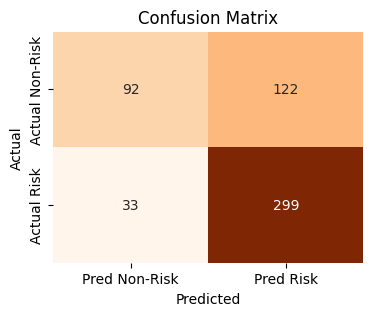

In [20]:
# create new filtered dfs with fewer non-risk headlines
new_filtered_spanish_df = create_filtered_df(spanish_df_3, spanish_df_4, new_spanish_percent)
new_filtered_portuguese_df = create_filtered_df(portuguese_df_3, portuguese_df_4, new_portuguese_percent)

# evaluates the results
filtered_spanish_classification_report_ = logistic_regression(new_filtered_spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
filtered_portuguese_classification_report_ = logistic_regression(new_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

## Visualize the results

The results show a significant improvement for risk headline recall for both langugaes.

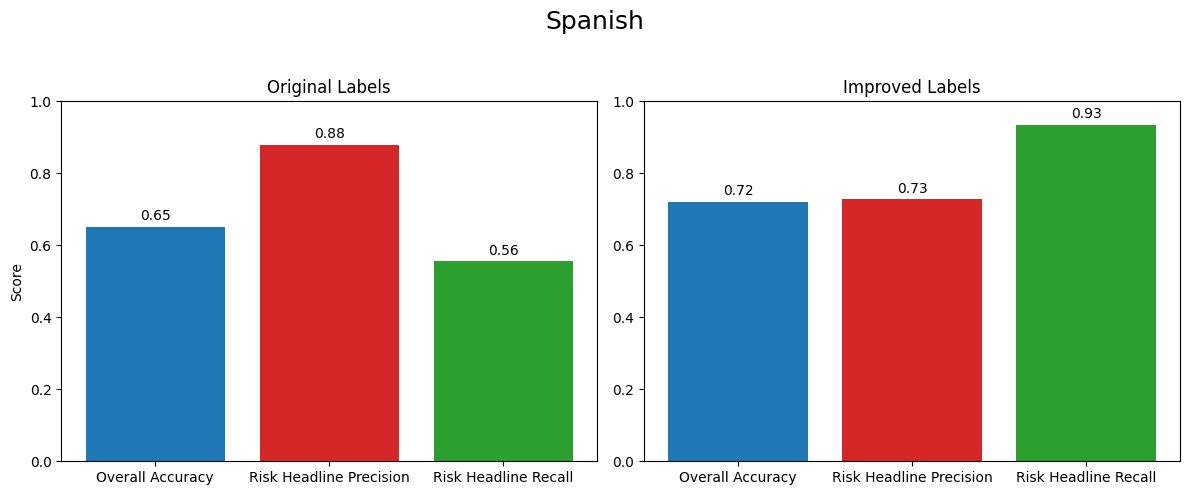

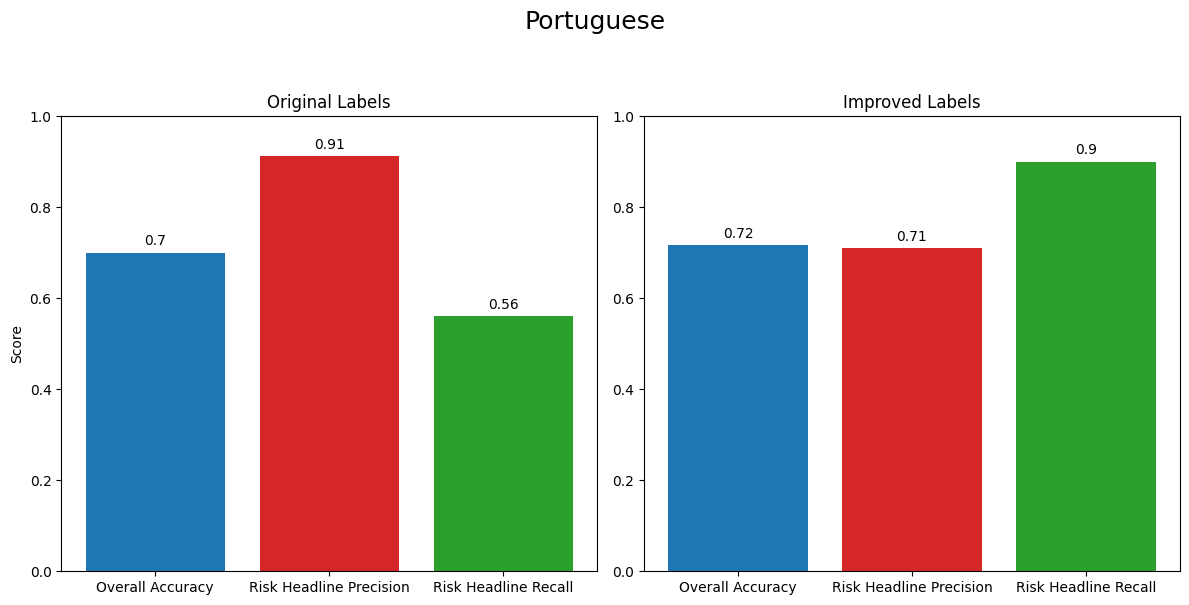

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# data
base_model_spanish = [
    unfiltered_spanish_classification_report_['accuracy'],
    unfiltered_spanish_classification_report_['1']['precision'],
    unfiltered_spanish_classification_report_['1']['recall']
]
new_model_spanish = [
    filtered_spanish_classification_report_['accuracy'],
    filtered_spanish_classification_report_['1']['precision'],
    filtered_spanish_classification_report_['1']['recall']
]
base_model_portuguese = [
    unfiltered_portuguese_classification_report_['accuracy'],
    unfiltered_portuguese_classification_report_['1']['precision'],
    unfiltered_portuguese_classification_report_['1']['recall']
]
new_model_portuguese = [
    filtered_portuguese_classification_report_['accuracy'],
    filtered_portuguese_classification_report_['1']['precision'],
    filtered_portuguese_classification_report_['1']['recall']
]

# labels for the statistics
labels = ['Overall Accuracy', 'Risk Headline Precision', 'Risk Headline Recall']
colors = ['tab:blue', 'tab:red', 'tab:green']

# create subplots for Spanish
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot baseline model stats for Spanish
bars = axs[0].bar(labels, base_model_spanish, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Spanish
bars = axs[1].bar(labels, new_model_spanish, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Spanish
fig.suptitle('Spanish', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_spanish_metrics.png', dpi=600, bbox_inches='tight')

# show the Spanish plot
plt.show()

# create subplots for Portuguese
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot baseline model stats for Portuguese
bars = axs[0].bar(labels, base_model_portuguese, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Portuguese
bars = axs[1].bar(labels, new_model_portuguese, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Portuguese
fig.suptitle('Portuguese', fontsize=18, y=1)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_portuguese_metrics.png', dpi=600, bbox_inches='tight')

# show the Portuguese plot
plt.show()

## Save dataframes

Finally, the refined dataframes are saved as CSV files for further use in additional notebooks.

In [22]:
# put aside data (for evaluation in other notebooks)
spanish_put_aside_df.to_csv('../Data/spanish_put_aside_df.csv', index=False)
portuguese_put_aside_df.to_csv('../Data/portuguese_put_aside_df.csv', index=False)

# filtered dataframes (for use in further training)
new_filtered_spanish_df.to_csv('../Data/spanish_df.csv', index=False)
new_filtered_portuguese_df.to_csv('../Data/portuguese_df.csv', index=False)